In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.preprocessing import LabelEncoder
import math

In [ ]:
df = pd.read_csv("data.csv")

In [ ]:
df

,Alt,Bar,Fri,Hun,Pat,Price,Rain,Res,Type,Est,Will Wait
0,Yes,No,No,Yes,Some,$$$,No,Yes,French,0-10,Yes
1,Yes,No,No,Yes,Full,S,No,No,Thai,30-60,No
2,No,Yes,No,No,Some,$,No,No,Burger,0-10,Yes
3,Yes,No,Yes,Yes,Full,$,Yes,No,Thai,10-30,Yes
4,Yes,No,Yes,No,Full,$$$,No,Yes,French,>60,No
5,No,Yes,No,Yes,Some,$$,Yes,Yes,Italian,0-10,Yes
6,No,Yes,No,No,None,$,Yes,No,Burger,0-10,No
7,No,No,No,Yes,Some,$$,Yes,Yes,Thai,0-10,Yes
8,No,Yes,Yes,No,Full,S,Yes,No,Burger,>60,No
9,Yes,Yes,Yes,Yes,Full,$$$,No,Yes,Italian,10-30,No


In [ ]:
df.shape

(12, 11)

In [ ]:
df.dtypes

Alt          object
Bar          object
Fri          object
Hun          object
Pat          object
Price        object
Rain         object
Res          object
Type         object
Est          object
Will Wait    object
dtype: object

In [ ]:
X = df[["Alt", "Bar", "Fri", "Hun", "Pat", "Rain", "Res", "Type", "Est"]]

In [ ]:
y = df[["Will Wait"]]

**Using General Coding**

In [ ]:
def get_unique_values(column):
  unique_values = column.value_counts()
  return unique_values.to_dict()

In [ ]:
def get_entropy(yes_len, no_len):
  total_len = yes_len + no_len
  yes_distribution = yes_len / total_len
  no_distribution = no_len / total_len
  entropy1 = 0
  entropy2 = 0
  if(yes_len > 0):
    entropy1 =  - (yes_distribution * math.log2(yes_distribution))
  if(no_len > 0):
    entropy2 =  - (no_distribution * math.log2(no_distribution))
  entropy = entropy1 + entropy2
  return entropy

In [ ]:
def get_entropy_total_dataset(y):
  total_rows = len(y)
  unique_values = get_unique_values(y["Will Wait"])
  yes_len = unique_values["Yes"]
  no_len = unique_values["No"]
  entropy = get_entropy(yes_len, no_len)
  return entropy

In [ ]:
def get_entropy_of_label(df, label, column, y):
    rows_with_label = df[df[column] == label]
    unique_values = get_unique_values(rows_with_label["Will Wait"])
    yes_len = unique_values.get("Yes", 0)
    no_len = unique_values.get("No", 0)
    entropy = get_entropy(yes_len, no_len)
    return entropy

In [ ]:
def get_entropy_of_labels(df, column, y):
  entropies = {}
  unique_values = get_unique_values(df[column])
  for label in unique_values:
    label_entropy = get_entropy_of_label(df, label, column, y)
    entropies[label] = (label_entropy, unique_values[label])
  sorted_entropies = {k: v for k, v in sorted(entropies.items(), key=lambda item: item[1][0])}
  return sorted_entropies

In [ ]:
def get_ig_of_column(column, X, y):
  total_rows = len(df)
  entropies = get_entropy_of_labels(df, column, y)
  ig = get_entropy_total_dataset(y)
  for key in entropies:
      ig -= (entropies[key][1] / total_rows) * (entropies[key][0])
  return ig

In [ ]:
def get_ig_of_columns(X, y):
  igs = {}
  for column in X.columns:
    ig = get_ig_of_column(column, X, y)
    igs[column] = ig
  sorted_igs = {k: v for k, v in sorted(igs.items(), key=lambda item: item[1], reverse=True)}
  return sorted_igs

In [ ]:
def iterations(df, X, y, igs, depth=0):
  igs = get_ig_of_columns(X, y)
  column = next(iter(igs.keys()))
  popped_value = igs.pop(column)
  entropies = get_entropy_of_labels(df, column, y)

  for label in entropies:
    indentation = "    " * depth
    print(f"{indentation}if {column} is '{label}'")
    if entropies[label][0] == 0:
      rows_with_label = df[df[column] == label]
      merged_df = pd.merge(df, rows_with_label, indicator=True, how='outer')
      df = merged_df[merged_df['_merge'] == 'left_only'].drop(columns='_merge')
      X = df[list(igs.keys())]
      y = df[["Will Wait"]]
      unique_values = get_unique_values(rows_with_label["Will Wait"])
      yes_len = unique_values.get("Yes", 0)
      no_len = unique_values.get("No", 0)
      print(f"{indentation}    then, Class: {'Yes' if yes_len > no_len else 'No'}")
    else:
      rows_with_label = df[df[column] == label]
      X = rows_with_label[list(igs.keys())]
      y = rows_with_label[["Will Wait"]]
      iterations(rows_with_label.copy(), X, y, igs, depth + 1)
  return algo

In [ ]:
def train(df, X, y):
  igs = get_ig_of_columns(X, y)
  iterations(df, X, y, igs)

In [ ]:
train(df, X, y)

if Pat is 'Some'
    then, Class: Yes
if Pat is 'None'
    then, Class: No
if Pat is 'Full'
    if Est is '>60'
        then, Class: No
    if Est is '30-60'
        if Hun is 'Yes'
            if Fri is 'No'
                then, Class: No
            if Fri is 'Yes'
                then, Class: Yes
    if Est is '10-30'
        if Hun is 'Yes'
            if Fri is 'Yes'
                if Rain is 'Yes'
                    then, Class: Yes
                if Rain is 'No'
                    then, Class: No


In [ ]:
df

,Alt,Bar,Fri,Hun,Pat,Price,Rain,Res,Type,Est,Will Wait,Predictions
0,Yes,No,No,Yes,Some,$$$,No,Yes,French,0-10,Yes,Yes
1,Yes,No,No,Yes,Full,S,No,No,Thai,30-60,No,No
2,No,Yes,No,No,Some,$,No,No,Burger,0-10,Yes,Yes
3,Yes,No,Yes,Yes,Full,$,Yes,No,Thai,10-30,Yes,Yes
4,Yes,No,Yes,No,Full,$$$,No,Yes,French,>60,No,No
5,No,Yes,No,Yes,Some,$$,Yes,Yes,Italian,0-10,Yes,Yes
6,No,Yes,No,No,None,$,Yes,No,Burger,0-10,No,No
7,No,No,No,Yes,Some,$$,Yes,Yes,Thai,0-10,Yes,Yes
8,No,Yes,Yes,No,Full,S,Yes,No,Burger,>60,No,No
9,Yes,Yes,Yes,Yes,Full,$$$,No,Yes,Italian,10-30,No,No


**Using Scikit-Learn**

In [ ]:
label_encoder = LabelEncoder()

In [ ]:
for column in X.columns:
  if X[column].dtype == 'object':
    X[column] = label_encoder.fit_transform(X[column])

In [ ]:
X

,Alt,Bar,Fri,Hun,Pat,Rain,Res,Type,Est
0,1,0,0,1,2,0,1,1,0
1,1,0,0,1,0,0,0,3,2
2,0,1,0,0,2,0,0,0,0
3,1,0,1,1,0,1,0,3,1
4,1,0,1,0,0,0,1,1,3
5,0,1,0,1,2,1,1,2,0
6,0,1,0,0,1,1,0,0,0
7,0,0,0,1,2,1,1,3,0
8,0,1,1,0,0,1,0,0,3
9,1,1,1,1,0,0,1,2,1


In [ ]:
label_encoder = LabelEncoder()
y.loc[:, "Will Wait"] = label_encoder.fit_transform(y["Will Wait"])

In [ ]:
y

,Will Wait
0,1
1,0
2,1
3,1
4,0
5,1
6,0
7,1
8,0
9,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
predictions = clf.predict(X_test)

In [ ]:
predictions

array([0, 1])

In [ ]:
accuracy = clf.score(X_test, y_test)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.50


In [ ]:
tree_rules = export_text(clf, feature_names=X.columns.to_list())
print("Decision Tree Rules:")
print(tree_rules)

Decision Tree Rules:
|--- Pat <= 1.50
|   |--- Hun <= 0.50
|   |   |--- class: 0
|   |--- Hun >  0.50
|   |   |--- Fri <= 0.50
|   |   |   |--- class: 0
|   |   |--- Fri >  0.50
|   |   |   |--- class: 1
|--- Pat >  1.50
|   |--- class: 1



In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
conf_matrix = confusion_matrix(y_test, predictions)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Confusion Matrix')

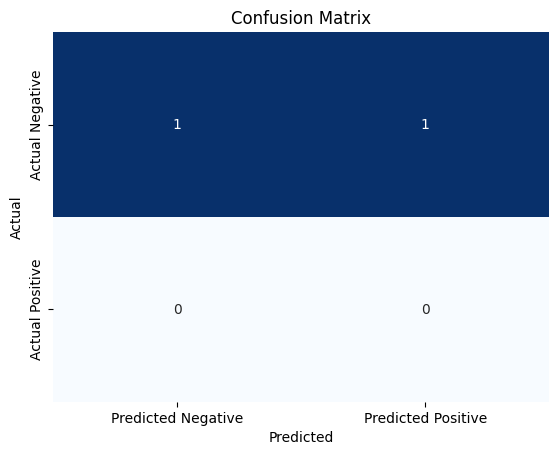

In [ ]:
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")